**Introduction and Background**
An issue often discussed about professional sports teams is the effects of extensive travel on performance, sleep, and recovery. For example, the Columbus Blue Jackets (CBJ) started as a Western Conference team, although their hometown, Columbus, OH, is in the Eastern time zone. As a Western Conference team, the CBJ traveled to the Pacific time zone, often playing games late at night, and having to return for next day games in the Eastern time zone. Could this type of travel impact player performance? If so, how can trainers and team management most effectively cope with this challenge? In 2013, the CBJ moved into the Eastern Conference and did not have to deal with the effects of time zone differences as much as the years prior. 

**Hypothesis and Plan**
My basic hypothesis is: *Travel from Eastern to Western time zones negatively impacts subsequent game performance of the Columbus Blue Jackets.* To test this hypothesis, I will first break the data into games played by the CBJ before 2013 and from 2013 on. The “game” table of the dataset contains datetime and time zone information, and I will look for the outcomes of the games (using wins and losses from the “game_teams_stats” table of the data) played in the Eastern time zone 1-2 days after late day games in the Pacific time zone. I would expect to see more losses after PST travel the evening before an EST game. I may also be able to dissect performance further by investigating individual plays. More shots, goals and hits (also from “game_team_stats” table) could indicate more team energy and recovery from the previous game played.


In [1]:
# Imports here

%matplotlib inline
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

**Data** I chose to analyze the NHL Game Data Kaggle set located here: https://www.kaggle.com/martinellis/nhl-game-data. This dataset contains results from National Hockey League games and individual player statistics as well as information on specific plays, such as shots, goals and stoppages in play, thus it is quite a comprehensive collection. This dataset is interesting to me because professional sports teams have begun to use data over the last 10 years to inform training, nutrition, and sleep schedules for their players. I selected two particular tables from this dataset that contain the variables of interest to me. These tables are described below.

In [2]:
# Uploading to this notebook the two CSV files that contain my fields of 
# particular interest.

from google.colab import files
uploaded = files.upload()

Saving game.csv to game.csv
Saving game_teams_stats.csv to game_teams_stats.csv


In [3]:
# Converting the files to DataFrames and getting some information about them.
# No null entries.

import io
game = pd.read_csv(io.BytesIO(uploaded['game.csv']))
teams_stats = pd.read_csv(io.BytesIO(uploaded['game_teams_stats.csv']))

game.info()
teams_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11434 entries, 0 to 11433
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   game_id                 11434 non-null  int64 
 1   season                  11434 non-null  int64 
 2   type                    11434 non-null  object
 3   date_time               11434 non-null  object
 4   date_time_GMT           11434 non-null  object
 5   away_team_id            11434 non-null  int64 
 6   home_team_id            11434 non-null  int64 
 7   away_goals              11434 non-null  int64 
 8   home_goals              11434 non-null  int64 
 9   outcome                 11434 non-null  object
 10  home_rink_side_start    11140 non-null  object
 11  venue                   11434 non-null  object
 12  venue_link              11434 non-null  object
 13  venue_time_zone_id      11434 non-null  object
 14  venue_time_zone_offset  11434 non-null  int64 
 15  ve

In [4]:
game.head()

,game_id,season,type,date_time,date_time_GMT,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz
0,2011030221,20112012,P,2012-04-29,2012-04-29T19:00:00Z,1,4,3,4,home win OT,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT
1,2011030222,20112012,P,2012-05-01,2012-05-01T23:30:00Z,1,4,4,1,away win REG,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT
2,2011030223,20112012,P,2012-05-03,2012-05-03T23:30:00Z,4,1,3,4,home win OT,left,Prudential Center,/api/v1/venues/null,America/New_York,-4,EDT
3,2011030224,20112012,P,2012-05-06,2012-05-06T23:30:00Z,4,1,2,4,home win REG,left,Prudential Center,/api/v1/venues/null,America/New_York,-4,EDT
4,2011030225,20112012,P,2012-05-08,2012-05-08T23:30:00Z,1,4,3,1,away win REG,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT


In [5]:
teams_stats.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways
0,2011030221,1,away,False,OT,Peter DeBoer,3,26,31,12,3,1,44.9,6,7
1,2011030221,4,home,True,OT,Peter Laviolette,4,36,27,6,6,1,55.1,13,4
2,2011030222,1,away,True,REG,Peter DeBoer,4,35,32,12,4,0,50.9,8,7
3,2011030222,4,home,False,REG,Peter Laviolette,1,20,24,32,5,0,49.1,9,6
4,2011030223,4,away,False,OT,Peter Laviolette,3,28,28,4,5,1,50.8,2,1


In [6]:
# Merging the two tables into one DataFrame using the game_id field.

all_stats = (pd.merge(game, teams_stats, on='game_id'))
all_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22868 entries, 0 to 22867
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   game_id                 22868 non-null  int64  
 1   season                  22868 non-null  int64  
 2   type                    22868 non-null  object 
 3   date_time               22868 non-null  object 
 4   date_time_GMT           22868 non-null  object 
 5   away_team_id            22868 non-null  int64  
 6   home_team_id            22868 non-null  int64  
 7   away_goals              22868 non-null  int64  
 8   home_goals              22868 non-null  int64  
 9   outcome                 22868 non-null  object 
 10  home_rink_side_start    22280 non-null  object 
 11  venue                   22868 non-null  object 
 12  venue_link              22868 non-null  object 
 13  venue_time_zone_id      22868 non-null  object 
 14  venue_time_zone_offset  22868 non-null

In [7]:
all_stats.head()

,game_id,season,type,date_time,date_time_GMT,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways
0,2011030221,20112012,P,2012-04-29,2012-04-29T19:00:00Z,1,4,3,4,home win OT,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT,1,away,False,OT,Peter DeBoer,3,26,31,12,3,1,44.9,6,7
1,2011030221,20112012,P,2012-04-29,2012-04-29T19:00:00Z,1,4,3,4,home win OT,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT,4,home,True,OT,Peter Laviolette,4,36,27,6,6,1,55.1,13,4
2,2011030222,20112012,P,2012-05-01,2012-05-01T23:30:00Z,1,4,4,1,away win REG,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT,1,away,True,REG,Peter DeBoer,4,35,32,12,4,0,50.9,8,7
3,2011030222,20112012,P,2012-05-01,2012-05-01T23:30:00Z,1,4,4,1,away win REG,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT,4,home,False,REG,Peter Laviolette,1,20,24,32,5,0,49.1,9,6
4,2011030223,20112012,P,2012-05-03,2012-05-03T23:30:00Z,4,1,3,4,home win OT,left,Prudential Center,/api/v1/venues/null,America/New_York,-4,EDT,4,away,False,OT,Peter Laviolette,3,28,28,4,5,1,50.8,2,1


**Methods** For this analysis I will create two DataFrames, one containing all records from before 2013 and one containing all records after. My plan is to interrogate the data where the CBJ is the away team in the Western conference versus when they are a home or away team in the Eastern conference, before and after 2013. I plan to look at the differences in games won, goals scored, hits, and shots.

First, I will check the distribution of my variables to ensure they are normally distributed. If they are, I can run ANOVA to see if there are any significant differences among the different groups. If there are, I can then check for pairwise relationships using Tukey's test. If the variables are not normally distributed, I have non-parametric tests that I can use to test for differences. My confidence interval will be set at 95%.

I initially intended to look for changes in performance of the CBJ in the Eastern time zone a period of 1-2 days after they had returned from a Western
conference game. I learned this this plan may be difficult to implement, and I may do this analysis at a later time, as it is beyond my current coding skills.

In [8]:
# Converts date_time to a timestamp and adds it as a new column. Then converts
# to Unix time for ease of time difference calculations.
# https://www.unixtimestamp.com/index.php

all_stats = all_stats.assign(time_stamp = (all_stats['date_time_GMT']))
all_stats['time_stamp'] = pd.to_datetime(all_stats['time_stamp']).astype(int) / 10**9

all_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22868 entries, 0 to 22867
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   game_id                 22868 non-null  int64  
 1   season                  22868 non-null  int64  
 2   type                    22868 non-null  object 
 3   date_time               22868 non-null  object 
 4   date_time_GMT           22868 non-null  object 
 5   away_team_id            22868 non-null  int64  
 6   home_team_id            22868 non-null  int64  
 7   away_goals              22868 non-null  int64  
 8   home_goals              22868 non-null  int64  
 9   outcome                 22868 non-null  object 
 10  home_rink_side_start    22280 non-null  object 
 11  venue                   22868 non-null  object 
 12  venue_link              22868 non-null  object 
 13  venue_time_zone_id      22868 non-null  object 
 14  venue_time_zone_offset  22868 non-null

In [9]:
# Replaces the Boolean values in the "won" column with the integers 1 for win is 
# True or 0 for win is False.

all_stats['won'] = all_stats['won'].map({True: 1, False: 0})

all_stats.head()

,game_id,season,type,date_time,date_time_GMT,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,time_stamp
0,2011030221,20112012,P,2012-04-29,2012-04-29T19:00:00Z,1,4,3,4,home win OT,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT,1,away,0,OT,Peter DeBoer,3,26,31,12,3,1,44.9,6,7,1.335726e+09
1,2011030221,20112012,P,2012-04-29,2012-04-29T19:00:00Z,1,4,3,4,home win OT,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT,4,home,1,OT,Peter Laviolette,4,36,27,6,6,1,55.1,13,4,1.335726e+09
2,2011030222,20112012,P,2012-05-01,2012-05-01T23:30:00Z,1,4,4,1,away win REG,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT,1,away,1,REG,Peter DeBoer,4,35,32,12,4,0,50.9,8,7,1.335915e+09
3,2011030222,20112012,P,2012-05-01,2012-05-01T23:30:00Z,1,4,4,1,away win REG,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT,4,home,0,REG,Peter Laviolette,1,20,24,32,5,0,49.1,9,6,1.335915e+09
4,2011030223,20112012,P,2012-05-03,2012-05-03T23:30:00Z,4,1,3,4,home win OT,left,Prudential Center,/api/v1/venues/null,America/New_York,-4,EDT,4,away,0,OT,Peter Laviolette,3,28,28,4,5,1,50.8,2,1,1.336088e+09


In [10]:
all_stats.head()

,game_id,season,type,date_time,date_time_GMT,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,time_stamp
0,2011030221,20112012,P,2012-04-29,2012-04-29T19:00:00Z,1,4,3,4,home win OT,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT,1,away,0,OT,Peter DeBoer,3,26,31,12,3,1,44.9,6,7,1.335726e+09
1,2011030221,20112012,P,2012-04-29,2012-04-29T19:00:00Z,1,4,3,4,home win OT,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT,4,home,1,OT,Peter Laviolette,4,36,27,6,6,1,55.1,13,4,1.335726e+09
2,2011030222,20112012,P,2012-05-01,2012-05-01T23:30:00Z,1,4,4,1,away win REG,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT,1,away,1,REG,Peter DeBoer,4,35,32,12,4,0,50.9,8,7,1.335915e+09
3,2011030222,20112012,P,2012-05-01,2012-05-01T23:30:00Z,1,4,4,1,away win REG,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT,4,home,0,REG,Peter Laviolette,1,20,24,32,5,0,49.1,9,6,1.335915e+09
4,2011030223,20112012,P,2012-05-03,2012-05-03T23:30:00Z,4,1,3,4,home win OT,left,Prudential Center,/api/v1/venues/null,America/New_York,-4,EDT,4,away,0,OT,Peter Laviolette,3,28,28,4,5,1,50.8,2,1,1.336088e+09


In [11]:
# Splitting the combined data into games before the 2013 season and games after
# and including the 2013 season. The CBJ moved to the Eastern conference
# starting with the 20132014 year.

# Note that the data is now split into years 20102011-20122013 and
# 20132014.

games_before_2013 = all_stats[all_stats['season'] < 20132014]

games_after_2013 = all_stats[all_stats['season'] >= 20132014]

print(games_before_2013.head())
print(games_after_2013.head())

      game_id    season type  ... giveaways takeaways    time_stamp
0  2011030221  20112012    P  ...         6         7  1.335726e+09
1  2011030221  20112012    P  ...        13         4  1.335726e+09
2  2011030222  20112012    P  ...         8         7  1.335915e+09
3  2011030222  20112012    P  ...         9         6  1.335915e+09
4  2011030223  20112012    P  ...         2         1  1.336088e+09

[5 rows x 31 columns]
        game_id    season type  ... giveaways takeaways    time_stamp
522  2016030171  20162017    P  ...        11         8  1.492137e+09
523  2016030171  20162017    P  ...        12         5  1.492137e+09
524  2016030172  20162017    P  ...        11         5  1.492310e+09
525  2016030172  20162017    P  ...        21         4  1.492310e+09
526  2016030173  20162017    P  ...         5         4  1.492481e+09

[5 rows x 31 columns]


In [12]:
games_before_2013.info()
games_after_2013.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6882 entries, 0 to 22277
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   game_id                 6882 non-null   int64  
 1   season                  6882 non-null   int64  
 2   type                    6882 non-null   object 
 3   date_time               6882 non-null   object 
 4   date_time_GMT           6882 non-null   object 
 5   away_team_id            6882 non-null   int64  
 6   home_team_id            6882 non-null   int64  
 7   away_goals              6882 non-null   int64  
 8   home_goals              6882 non-null   int64  
 9   outcome                 6882 non-null   object 
 10  home_rink_side_start    6566 non-null   object 
 11  venue                   6882 non-null   object 
 12  venue_link              6882 non-null   object 
 13  venue_time_zone_id      6882 non-null   object 
 14  venue_time_zone_offset  6882 non-null  

In [13]:
# Selecting games where the AWAY team is the Columbus Blue Jackets (# 29)
# and the time zone is PDT as a DataFrame.
games_before_2013_pdt_away = games_before_2013[(games_before_2013['venue_time_zone_tz'] == 'PDT') & (games_before_2013['away_team_id'] == 29) & (games_before_2013['team_id'] == 29)]
games_after_2013_pdt_away = games_after_2013[(games_after_2013['venue_time_zone_tz'] == 'PDT') & (games_after_2013['away_team_id'] == 29) & (games_after_2013['team_id'] == 29)]

# Selecting the games where the AWAY team is the Columbus Blue Jackets
# and the time zone is EDT as a DataFrame.
games_before_2013_edt_away = games_before_2013[(games_before_2013['venue_time_zone_tz'] == 'EDT') & (games_before_2013['away_team_id'] == 29) & (games_before_2013['team_id'] == 29)]
games_after_2013_edt_away = games_after_2013[(games_after_2013['venue_time_zone_tz'] == 'EDT') & (games_after_2013['away_team_id'] == 29) & (games_after_2013['team_id'] == 29)]


# Note: If I wanted to select the CBJ's both home AND away games, I would have 
# written the code below. However, I only want to look at when the CBJ is 
# AWAY in the Eastern time zone because the "won" column specifies the result
# only for the home team, and I want to keep the analysis consistent.
# games_before_2013_edt = games_before_2013[(games_before_2013['venue_time_zone_tz'] == 'EDT') & ((games_before_2013['away_team_id'] == 29) | (games_before_2013['home_team_id'] == 29))]
# games_after_2013_edt = games_after_2013[(games_after_2013['venue_time_zone_tz'] == 'EDT') & ((games_after_2013['away_team_id'] == 29) | (games_after_2013['home_team_id'] == 29))]

# A quick check of one of the new DataFrames...
games_after_2013_edt_away.head()


,game_id,season,type,date_time,date_time_GMT,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,time_stamp
796,2016030141,20162017,P,2017-04-12,2017-04-12T23:30:00Z,29,5,1,3,home win REG,left,PPG Paints Arena,/api/v1/venues/null,America/New_York,-4,EDT,29,away,0,REG,John Tortorella,1,32,49,6,2,0,45.3,2,6,1.492040e+09
798,2016030142,20162017,P,2017-04-14,2017-04-14T23:00:00Z,29,5,1,4,home win REG,left,PPG Paints Arena,/api/v1/venues/null,America/New_York,-4,EDT,29,away,0,REG,John Tortorella,1,40,51,28,2,0,43.1,2,2,1.492211e+09
804,2016030145,20162017,P,2017-04-20,2017-04-20T23:00:00Z,29,5,2,5,home win REG,left,PPG Paints Arena,/api/v1/venues/null,America/New_York,-4,EDT,29,away,0,REG,John Tortorella,2,51,37,8,3,1,41.8,5,3,1.492729e+09
1134,2013030131,20132014,P,2014-04-16,2014-04-16T23:30:00Z,29,5,3,4,home win REG,left,CONSOL Energy Center,/api/v1/venues/null,America/New_York,-4,EDT,29,away,0,REG,Todd Richards,3,34,48,6,4,1,43.7,2,5,1.397691e+09
1136,2013030132,20132014,P,2014-04-19,2014-04-19T23:00:00Z,29,5,4,3,away win OT,left,CONSOL Energy Center,/api/v1/venues/null,America/New_York,-4,EDT,29,away,1,OT,Todd Richards,4,45,51,16,6,2,56.6,3,5,1.397948e+09


In [14]:
# Trying to decide which variables to use for the analysis. I will first look at
# how many games were won. How large is each group?
# Unfortunately, these sample sizes are too small for accurate analysis.

print('PDT games won before 2013 sample size:', len(games_before_2013_pdt_away[games_before_2013_pdt_away.won == 1]))
print('PDT games won after 2013 sample size:', len(games_after_2013_pdt_away[games_after_2013_pdt_away.won == 1]))
print('EDT games won before 2013 sample size:', len(games_before_2013_edt_away[games_before_2013_edt_away.won == 1]))
print('EDT games won after 2013 sample size:', len(games_after_2013_edt_away[games_after_2013_edt_away.won == 1]))


PDT games won before 2013 sample size: 8
PDT games won after 2013 sample size: 10
EDT games won before 2013 sample size: 10
EDT games won after 2013 sample size: 73


In [15]:
# However, I later learned that TWO team moved from the Western to the Eastern
# Conference during the 20132014 season: CBJ and the Detroit Red Wings (#17).
# So, I added DET to the analysis here.

# Selecting games where the AWAY team is the Columbus Blue Jackets (# 29) or the
# Detroit Red Wings (# 17) and the time zone is PDT as a DataFrame.
games_before_2013_pdt_away_two_teams = games_before_2013[(games_before_2013['venue_time_zone_tz'] == 'PDT') & (((games_before_2013['away_team_id'] == 29) & (games_before_2013['team_id'] == 29)) | ((games_before_2013['away_team_id'] == 17) & (games_before_2013['team_id'] == 17)))]
games_after_2013_pdt_away_two_teams = games_after_2013[(games_after_2013['venue_time_zone_tz'] == 'PDT') & (((games_after_2013['away_team_id'] == 29) & (games_after_2013['team_id'] == 29)) | ((games_after_2013['away_team_id'] == 17) & (games_after_2013['team_id'] == 17)))]

# Selecting the games where the AWAY team is the Columbus Blue Jackets
# and the time zone is EDT as a DataFrame.
games_before_2013_edt_away_two_teams = games_before_2013[(games_before_2013['venue_time_zone_tz'] == 'EDT') & (((games_before_2013['away_team_id'] == 29) & (games_before_2013['team_id'] == 29)) | ((games_before_2013['away_team_id'] == 17) & (games_before_2013['team_id'] == 17)))]
games_after_2013_edt_away_two_teams = games_after_2013[(games_after_2013['venue_time_zone_tz'] == 'EDT') & (((games_after_2013['away_team_id'] == 29) & (games_after_2013['team_id'] == 29)) | ((games_after_2013['away_team_id'] == 17) & (games_after_2013['team_id'] == 17)))]

# Checking one of the new tables.
games_before_2013_pdt_away_two_teams.head()


,game_id,season,type,date_time,date_time_GMT,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,time_stamp
54,2010030241,20102011,P,2011-04-30,2011-04-30T02:00:00Z,17,28,1,2,home win OT,left,HP Pavilion at San Jose,/api/v1/venues/null,America/Los_Angeles,-7,PDT,17,away,0,OT,Mike Babcock,1,25,30,16,2,0,50.0,11,12,1.304129e+09
56,2010030242,20102011,P,2011-05-01,2011-05-01T19:00:00Z,17,28,1,2,home win REG,left,HP Pavilion at San Jose,/api/v1/venues/null,America/Los_Angeles,-7,PDT,17,away,0,REG,Mike Babcock,1,34,31,14,6,1,46.5,11,5,1.304276e+09
62,2010030245,20102011,P,2011-05-09,2011-05-09T00:00:00Z,17,28,4,3,away win REG,left,HP Pavilion at San Jose,/api/v1/venues/null,America/Los_Angeles,-7,PDT,17,away,1,REG,Mike Babcock,4,22,25,10,2,0,49.2,13,6,1.304899e+09
66,2010030247,20102011,P,2011-05-13,2011-05-13T01:00:00Z,17,28,2,3,home win REG,left,HP Pavilion at San Jose,/api/v1/venues/null,America/Los_Angeles,-7,PDT,17,away,0,REG,Mike Babcock,2,40,27,6,4,0,50.0,13,5,1.305248e+09
174,2012030161,20122013,P,2013-05-01,2013-05-01T02:30:00Z,17,24,1,3,home win REG,left,Honda Center,/api/v1/venues/null,America/Los_Angeles,-7,PDT,17,away,0,REG,Mike Babcock,1,22,24,8,4,1,51.8,13,3,1.367375e+09


In [16]:
# Checking new sample size. Better, but still not great.

print('PDT games won by CBJ and DET before 2013 sample size:', len(games_before_2013_pdt_away_two_teams[games_before_2013_pdt_away_two_teams.won == 1]))
print('PDT games won by CBJ and DET after 2013 sample size:', len(games_after_2013_pdt_away_two_teams[games_after_2013_pdt_away_two_teams.won == 1]))
print('EDT games won by CBJ and DET before 2013 sample size:', len(games_before_2013_edt_away_two_teams[games_before_2013_edt_away_two_teams.won == 1]))
print('EDT games won by CBJ and DET after 2013 sample size:', len(games_after_2013_edt_away_two_teams[games_after_2013_edt_away_two_teams.won == 1]))

PDT games won by CBJ and DET before 2013 sample size: 22
PDT games won by CBJ and DET after 2013 sample size: 22
EDT games won by CBJ and DET before 2013 sample size: 23
EDT games won by CBJ and DET after 2013 sample size: 130


In [17]:
# Instead of wins, I will check other variables that could indicate performance.
# Here I am checking how many goals were scored. Getting better!

print('PDT goals scored before 2013 sample size:', len(games_before_2013_pdt_away_two_teams[games_before_2013_pdt_away_two_teams.away_goals != 0]))
print('PDT goals scored after 2013 sample size:', len(games_after_2013_pdt_away_two_teams[games_after_2013_pdt_away_two_teams.away_goals != 0]))
print('EDT goals scored before 2013 sample size:', len(games_before_2013_edt_away_two_teams[games_before_2013_edt_away_two_teams.away_goals != 0]))
print('EDT goals scored after 2013 sample size:', len(games_after_2013_edt_away_two_teams[games_after_2013_edt_away_two_teams.away_goals != 0]))

PDT goals scored before 2013 sample size: 48
PDT goals scored after 2013 sample size: 42
EDT goals scored before 2013 sample size: 50
EDT goals scored after 2013 sample size: 288


In [18]:
# Checking shots and hits. These are good samples to analyze.
print('PDT shot attempts before 2013 sample size:', len(games_before_2013_pdt_away_two_teams[games_before_2013_pdt_away_two_teams.shots != 0]))
print('PDT shot attempts after 2013 sample size:', len(games_after_2013_pdt_away_two_teams[games_after_2013_pdt_away_two_teams.shots != 0]))
print('EDT shot attempts before 2013 sample size:', len(games_before_2013_edt_away_two_teams[games_before_2013_edt_away_two_teams.shots != 0]))
print('EDT shot attempts after 2013 sample size:', len(games_after_2013_edt_away_two_teams[games_after_2013_edt_away_two_teams.shots != 0]))
print('PDT hits before 2013 sample size:', len(games_before_2013_pdt_away_two_teams[games_before_2013_pdt_away_two_teams.hits != 0]))
print('PDT hits after 2013 sample size:', len(games_after_2013_pdt_away_two_teams[games_after_2013_pdt_away_two_teams.hits != 0]))
print('EDT hits before 2013 sample size:', len(games_before_2013_edt_away_two_teams[games_before_2013_edt_away_two_teams.hits != 0]))
print('EDT hits after 2013 sample size:', len(games_after_2013_edt_away_two_teams[games_after_2013_edt_away_two_teams.hits != 0]))

PDT shot attempts before 2013 sample size: 53
PDT shot attempts after 2013 sample size: 45
EDT shot attempts before 2013 sample size: 53
EDT shot attempts after 2013 sample size: 305
PDT hits before 2013 sample size: 53
PDT hits after 2013 sample size: 45
EDT hits before 2013 sample size: 53
EDT hits after 2013 sample size: 305


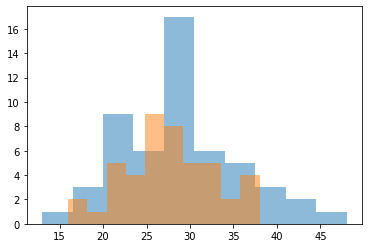

DescribeResult(nobs=53, minmax=(13, 48), mean=28.471698113207548, variance=47.561683599419446, skewness=0.46485416493583803, kurtosis=0.4075112275856858)
DescribeResult(nobs=45, minmax=(16, 38), mean=27.377777777777776, variance=27.74040404040404, skewness=0.10276353766223147, kurtosis=-0.5099513446120922)


In [19]:
# I will first check for normality of the shots during the PDT games.  

pdt_before_2013_shots = games_before_2013_pdt_away_two_teams[games_before_2013_pdt_away_two_teams['shots'] != 0]

pdt_after_2013_shots = games_after_2013_pdt_away_two_teams[games_after_2013_pdt_away_two_teams['shots'] != 0]


plt.hist(pdt_before_2013_shots['shots'], alpha = .5)
plt.hist(pdt_after_2013_shots['shots'], alpha = .5)
plt.show()

print(stats.describe(pdt_before_2013_shots['shots']))
print(stats.describe(pdt_after_2013_shots['shots']))

# These look normally distributed to me and skewness and kurtosis
# are fine.

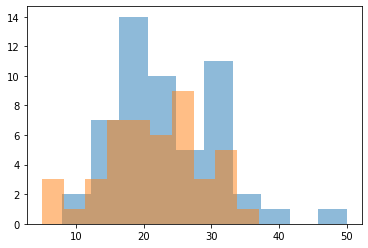

DescribeResult(nobs=53, minmax=(8, 50), mean=23.132075471698112, variance=59.078374455732956, skewness=0.8699697828759124, kurtosis=1.3414098697533703)
DescribeResult(nobs=45, minmax=(5, 37), mean=21.31111111111111, variance=56.082828282828274, skewness=-0.14143510485387795, kurtosis=-0.524431187149188)


In [20]:
# I will then check for normality of the hits during the PDT games.  

pdt_before_2013_hits = games_before_2013_pdt_away_two_teams[games_before_2013_pdt_away_two_teams['hits'] != 0]

pdt_after_2013_hits = games_after_2013_pdt_away_two_teams[games_after_2013_pdt_away_two_teams['hits'] != 0]


plt.hist(pdt_before_2013_hits['hits'], alpha = .5)
plt.hist(pdt_after_2013_hits['hits'], alpha = .5)
plt.show()

print(stats.describe(pdt_before_2013_hits['hits']))
print(stats.describe(pdt_after_2013_hits['hits']))

# Also look normally distributed, and skewness and kurtosis good.

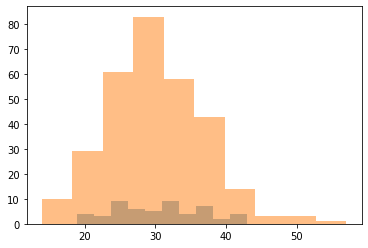

DescribeResult(nobs=53, minmax=(19, 43), mean=30.471698113207548, variance=40.25399129172714, skewness=0.1849798067996665, kurtosis=-0.8267762791692177)
DescribeResult(nobs=305, minmax=(14, 57), mean=29.898360655737704, variance=45.466609145815355, skewness=0.41368473385695126, kurtosis=0.5536977245652177)


In [21]:
# Normality of the shots during the EDT games.  

edt_before_2013_shots = games_before_2013_edt_away_two_teams[games_before_2013_edt_away_two_teams['shots'] != 0]

edt_after_2013_shots = games_after_2013_edt_away_two_teams[games_after_2013_edt_away_two_teams['shots'] != 0]


plt.hist(edt_before_2013_shots['shots'], alpha = .5)
plt.hist(edt_after_2013_shots['shots'], alpha = .5)
plt.show()

print(stats.describe(edt_before_2013_shots['shots']))
print(stats.describe(edt_after_2013_shots['shots']))

# Normally distributed and skewness and kurtosis are fine.

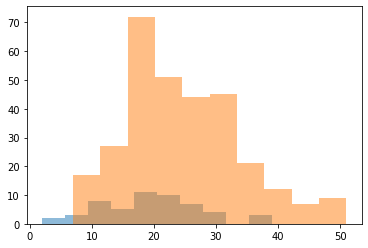

DescribeResult(nobs=53, minmax=(2, 39), mean=19.566037735849058, variance=65.59651669085632, skewness=0.10941500159172018, kurtosis=-0.09694176917371466)
DescribeResult(nobs=305, minmax=(7, 51), mean=24.527868852459015, variance=87.11188524590163, skewness=0.6543620290874494, kurtosis=0.19957563575182524)


In [22]:
# Finally, normality of the hits during the EDT games.  

edt_before_2013_hits = games_before_2013_edt_away_two_teams[games_before_2013_edt_away_two_teams['hits'] != 0]

edt_after_2013_hits = games_after_2013_edt_away_two_teams[games_after_2013_edt_away_two_teams['hits'] != 0]


plt.hist(edt_before_2013_hits['hits'], alpha = .5)
plt.hist(edt_after_2013_hits['hits'], alpha = .5)
plt.show()

print(stats.describe(edt_before_2013_hits['hits']))
print(stats.describe(edt_after_2013_hits['hits']))

# Normally distributed and skewness and kurtosis good.

In [23]:
# I'll check for normality again just to be sure with Shapiro-Wilk test.
print(stats.shapiro(pdt_before_2013_shots['shots']))
print(stats.shapiro(pdt_after_2013_shots['shots']))

print(stats.shapiro(edt_before_2013_hits['hits']))
print(stats.shapiro(edt_after_2013_hits['hits']))

# W is close to 1 for each variable, and each p value is greater than 0.05
# EXCEPT for edt_after_2013. So all are normally distributed but 
# hits in the EDT after 2013.

(0.9782990217208862, 0.4435156583786011)
(0.9796275496482849, 0.6047382354736328)
(0.9860527515411377, 0.7892889380455017)
(0.9661863446235657, 1.4824165646132315e-06)


In [24]:
# Although most of the groups are normal, due to the small sample sizes and the
# non-normal result for the hits in the edt_after_2013 group, I am going to be 
# conservative and run a Kruskal-Wallis Test (assuming non-normality) to compare
# differences in the four groups. (I'm also going to run an ANOVA just to 
# compare the results to Kruskal-Wallis.)

# One way ANOVA for shots
stats.f_oneway(pdt_before_2013_shots['shots'], pdt_after_2013_shots['shots'], edt_before_2013_shots['shots'], edt_after_2013_shots['shots'])

# Test is significant - p value less than 0.05.

F_onewayResult(statistic=2.7353482035510184, pvalue=0.04317766862653993)

In [25]:
# One way ANOVA for hits

stats.f_oneway(pdt_before_2013_hits['hits'], pdt_after_2013_hits['hits'], edt_before_2013_hits['hits'], edt_after_2013_hits['hits'])

# Test is also significant - p value less than 0.05.

F_onewayResult(statistic=5.803713524242614, pvalue=0.0006730950449886126)

In [26]:
# Kruskal-Wallis Test for shots
stats.kruskal(pdt_before_2013_shots['shots'], pdt_after_2013_shots['shots'], edt_before_2013_shots['shots'], edt_after_2013_shots['shots'])

# This one checks out as well - significant result.

KruskalResult(statistic=8.114359410775528, pvalue=0.04370643078566617)

In [27]:
# Kruskal-Wallis Test for hits
stats.kruskal(pdt_before_2013_hits['hits'], pdt_after_2013_hits['hits'], edt_before_2013_hits['hits'], edt_after_2013_hits['hits'])

# Also a significant result. So, all tests have shown that there are 
# significant differences between groups.

KruskalResult(statistic=12.812030768986753, pvalue=0.005061245914975408)

In [28]:
# Now that I know there are significant differences between groups, I want to 
# find out specifically which groups are different. I prefer to run Tukey's HSD
# Test, but given the way I broke my data into multiple groups, I am not sure 
# this is possible (and I am not sure how to run that analysis). Therefore, I 
# will check the two t-tests of interest to me -
# shots and hits in PDT versus EDT before 2013 and shots and hits in PDT versus
# EDT after 2013.

stats.ttest_ind
# shots
print(stats.ttest_ind(pdt_before_2013_shots['shots'], edt_before_2013_shots['shots']))
print(stats.ttest_ind(pdt_after_2013_shots['shots'], edt_after_2013_shots['shots']))

# hits
print(stats.ttest_ind(pdt_before_2013_hits['hits'], edt_before_2013_hits['hits']))
print(stats.ttest_ind(pdt_after_2013_hits['hits'], edt_after_2013_hits['hits']))

# I found three significant differences of possible interest:
# There were no differences in shots between time zones before 2013, but there
# was a significant difference in shots after 2013.

# Hits before 2013 and after are significantly different between time zones.

Ttest_indResult(statistic=-1.5537527445215253, pvalue=0.12328134467742305)
Ttest_indResult(statistic=-2.400787949346868, pvalue=0.016884157305558672)
Ttest_indResult(statistic=2.325061101981969, pvalue=0.022010845150674863)
Ttest_indResult(statistic=-2.20855600013743, pvalue=0.027856846137347353)


In [29]:
# Checking the confidence intervals for hits before 2013

def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return("The difference in means at the 95% confidence interval (two-tail) is between "+str(ci_lower)+" and "+str(ci_upper)+".")

print(get_95_ci(pdt_before_2013_hits['hits'], edt_before_2013_hits['hits']))

# Before 2013, when playing in EDT, the two teams are recording less hits than
# when in PDT. 


The difference in means at the 95% confidence interval (two-tail) is between -6.572166889317792 and -0.5599085823803169.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[[Text(0, 0, 'pdt_before_2013_hits'), Text(0, 0, 'edt_before_2013_hits')]]

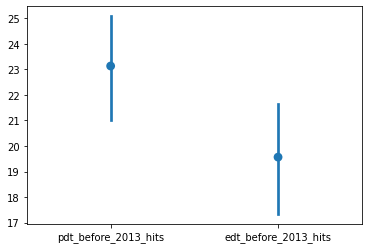

In [30]:
# Visualization of the differences between means.
import seaborn as sns
g = sns.pointplot(data=[pdt_before_2013_hits['hits'],
edt_before_2013_hits['hits']], join=False)
g.set(xticklabels = ['pdt_before_2013_hits', 'edt_before_2013_hits'])

In [31]:
# Checking the confidence intervals for hits after 2013

def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return("The difference in means at the 95% confidence interval (two-tail) is between "+str(ci_lower)+" and "+str(ci_upper)+".")

print(get_95_ci(pdt_after_2013_hits['hits'], edt_after_2013_hits['hits']))

# After 2013, when playing in EDT, the two teams are recording more hits than
# when in PDT. 


The difference in means at the 95% confidence interval (two-tail) is between 0.790868495624629 and 5.642646987071181.


[[Text(0, 0, 'pdt_after_2013_hits'), Text(0, 0, 'edt_after_2013_hits')]]

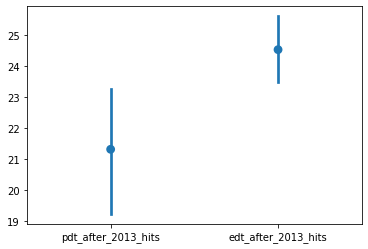

In [32]:
# Visualization of the differences in means.

g = sns.pointplot(data=[pdt_after_2013_hits['hits'],
edt_after_2013_hits['hits']], join=False)
g.set(xticklabels = ['pdt_after_2013_hits', 'edt_after_2013_hits'])

In [33]:
# Checking the confidence intervals for shots after 2013

def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return("The difference in means at the 95% confidence interval (two-tail) is between "+str(ci_lower)+" and "+str(ci_upper)+".")

print(get_95_ci(pdt_after_2013_shots['shots'], edt_after_2013_shots['shots']))

# The 95% confidence interval suggests that the difference in the average 
# shots between the PDT and EDT time zones after 2013 is between about 1 and 4.
# In other words, after 2013, when playing in EDT, the two teams are recording
# more shots than when in PDT.


The difference in means at the 95% confidence interval (two-tail) is between 0.8056956961587787 and 4.235470059761077.


[[Text(0, 0, 'pdt_after_2013_shots'), Text(0, 0, 'edt_after_2013_shots')]]

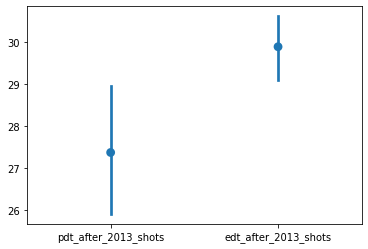

In [34]:
# Another graphical representation of the difference in means. 

g = sns.pointplot(data=[pdt_after_2013_shots['shots'],
edt_after_2013_shots['shots']], join=False)
g.set(xticklabels = ['pdt_after_2013_shots', 'edt_after_2013_shots'])

[[Text(0, 0, 'pdt_before_2013_shots'), Text(0, 0, 'edt_before_2013_shots')]]

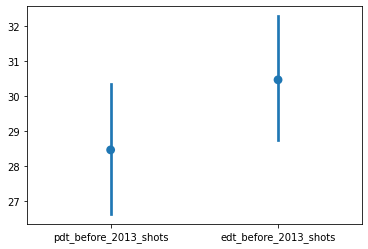

In [35]:
# Check of shots before 2013. The range of means overlap. No significant difference.
g = sns.pointplot(data=[pdt_before_2013_shots['shots'],
edt_before_2013_shots['shots']], join=False)
g.set(xticklabels = ['pdt_before_2013_shots', 'edt_before_2013_shots'])

**Results** Based on a visual inspection, the variables of interest appeared normally distributed, but Shapiro-Wilk testing suggested otherwise, so I chose to run a non-parametric test as well as ANOVA. Both tests produced the same result: there was a significant difference between
performance before and after 2013; i.e., based on a p-value of 0.05, I cannot reject the null that there is no significant difference in means.

To see if these differences were a result of the change in time zones, I ran pairwise t-tests (would have preferred to run Tukey's test but couldn't), and there were significant differences in performance indicators between the time zones both before and after 2013. 


**Discussion and Recommendation** Based on these results alone, I conclude that there were significant effects of travel to different time zones on two indicators of hockey performance (hits, shots) for the Columbus Blue Jackets and the Detroit Red Wings when comparing performance before 2013 and after 2013. However, this was only two teams. As a next step in the process, I would like to analyze time zone travel effects on performance of other Eastern conference NHL teams. It may also be useful to break the data into times when each Eastern team remains in EDT for at least a week to see if performance indicators improve during these instances. This could serve as a "Control" group. Importantly, I would like to be able to analyze specifically the effects on peformance indicators in Eastern time zone 1-2 days after return travel from the Western time zone. The current analysis was not granular enough to pick up these effects. Overall, it appeared that the teams analyzed recorded more shots and hits after the move to the Eastern conference in year 2013. 

Although the results were significant, many factors could account for these differences. For example, perhaps changes in team rosters after 2013 for these two teams, such as acquisition of stronger shooters, could lead to more shots. Maybe changes in coaching focus or training led to more shot taking or hits. A deeper analysis of the data overall would need to be conducted. Again, it would be preferable to study all teams.

In terms of recovery and training, I would consider this analysis preliminary evidence that NHL coaches and management should pay attention to the effects of time zone travel on hockey performance. Teams might consider nutritional and physical recovery measures (massage, ice baths, physical therapy, etc.) to maximize training and counteract any issues encountered by extensive travel. Perhaps additional data to include surveys about subjective measures of sleep quality, well-being, pain, etc. could add more insight and provide a complete picture of training status and recovery for each team.